# Sparse Gaussian Process Regression (SGPR)

## Imports and Dependencies

In [14]:
import sys
import time
import warnings

sys.path.insert(0,"..")

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

rng = np.random.RandomState(69)
tf.random.set_seed(69)
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
gpflow.config.set_default_float(np.float64)

## Generating Data

In this notebook, we generate an artificial dataset consisting of noisy observations from a test function:

\begin{equation}
    f(x) = \sin (3 \pi x) + 0.3 \cos (9 \pi x) + \frac{ \sin (7 \pi x) }{ 2 }
\end{equation}

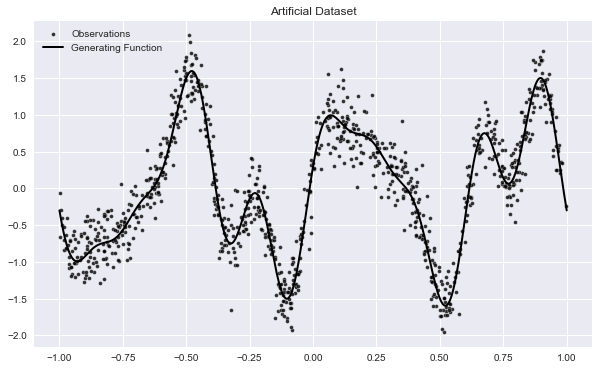

In [15]:
def func(x):
    return np.sin(x*3* np.pi) + 0.3*np.cos(x*9*np.pi) + 0.5*np.sin(x*7*np.pi)

# Number of training observations and noise scale
N = 1000
sigma_n = 0.25

# Inputs and (noisy) outputs
X = rng.rand(N, 1) * 2 - 1 
y = func(X) + sigma_n * rng.randn(N, 1) 
data = (X, y)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(np.linspace(-1.0, 1.0, 1000), func(np.linspace(-1.0, 1.0, 1000)), lw=2, 
        label="Generating Function", c="k")
ax.set_title("Artificial Dataset")
ax.legend()
plt.show()

## Exact Inference

### Building the GPR Model

As a baseline for comparison, we will train an exact GP regression model on the dataset.

In [16]:
# Set kernel
kernel = gpflow.kernels.SquaredExponential()

# Initialise the exact GP model
gpr = gpflow.models.GPR(data, kernel, noise_variance=sigma_n**2)

### GPR Prior Predictions

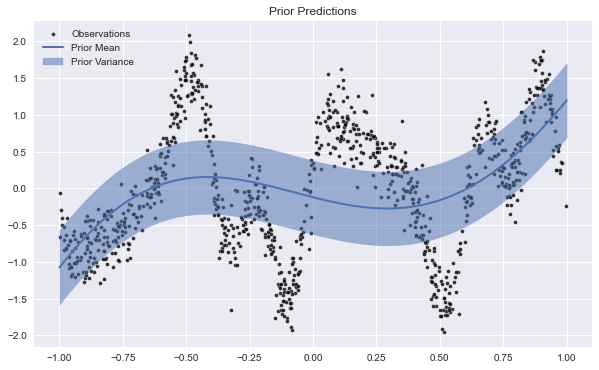

In [17]:
# Prior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
gpr_prior_mean, gpr_prior_var = gpr.predict_y(X_pred)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], gpr_prior_mean[:, 0], c="C0", lw=2, label="Prior Mean")
ax.fill_between(X_pred[:, 0], gpr_prior_mean[:, 0] + 2*np.sqrt(gpr_prior_var[:, 0]), 
                gpr_prior_mean[:, 0] - 2*np.sqrt(gpr_prior_var[:, 0]), color="C0", 
                alpha=0.5, label="Prior Variance")
ax.set_title("Prior Predictions")
ax.legend()
plt.show()

### Optimising the GPR Model

In [18]:
optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(gpr.training_loss, 
                   gpr.trainable_variables,
                   options={"maxiter": 1000, "disp": False})

      fun: 118.21572995784345
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.21088797e-05, -1.89081523e-06,  8.60334062e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 30
     njev: 46
   status: 0
  success: True
        x: array([-2.3214417 ,  0.61105967, -2.70925469])

### GPR Posterior Predictions

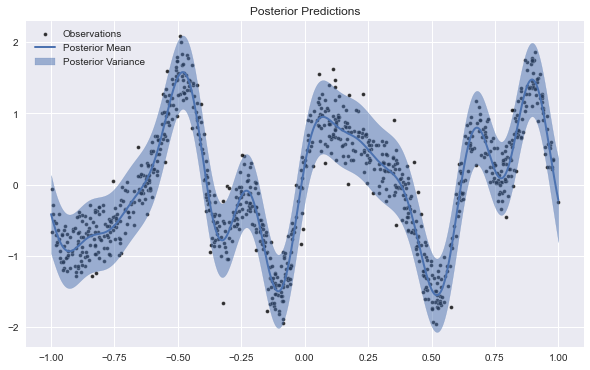

In [33]:
# Posterior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
gpr_post_mean, gpr_post_var = gpr.predict_y(X_pred)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], gpr_post_mean[:, 0], c="C0", lw=2, label="Posterior Mean")
ax.fill_between(X_pred[:, 0], gpr_post_mean[:, 0] + 2*np.sqrt(gpr_post_var[:, 0]), 
                gpr_post_mean[:, 0] - 2*np.sqrt(gpr_post_var[:, 0]), color="C0", 
                alpha=0.5, label="Posterior Variance")
ax.set_title("Posterior Predictions")
ax.legend()
plt.show()

## Approximate Inference

### Building the SGPR Model

Sparse variational Gaussian processes (SVGP's) approximate the true GP posterior by learning a set of noiseless function values (inducing outputs) at specific input locations (inducing inputs) which effectively "summarise" the training dataset. This is done by optimising an approximate variational distribution over the inducing outputs to maximise a lower bound on the marginal likelihood.

In [20]:
# Initialise inducing points
M = 50
Z = rng.rand(M, 1) * 2 - 1

# Set kernel
kernel = gpflow.kernels.SquaredExponential()

# Initialise the SGPR model
sgpr = gpflow.models.SGPR(data, kernel, Z, noise_variance=sigma_n**2)

### Prior Predictions

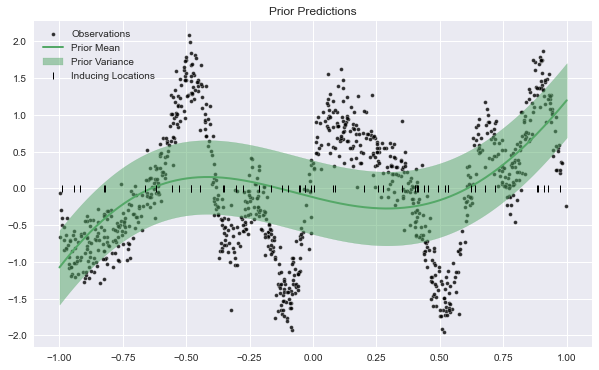

In [21]:
# Prior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
sgpr_prior_mean, sgpr_prior_var = sgpr.predict_y(X_pred)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], sgpr_prior_mean[:, 0], c="C1", lw=2, label="Prior Mean")
ax.fill_between(X_pred[:, 0], sgpr_prior_mean[:, 0] + 2*np.sqrt(sgpr_prior_var[:, 0]), 
                sgpr_prior_mean[:, 0] - 2*np.sqrt(sgpr_prior_var[:, 0]), color="C1", 
                alpha=0.5, label="Prior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations")
ax.set_title("Prior Predictions")
ax.legend()
plt.show()

### Optimising the Model

In [22]:
optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(sgpr.training_loss, 
                   sgpr.trainable_variables,
                   options={"maxiter": 1000, "disp": False})

      fun: 118.22128842933694
 hess_inv: <53x53 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.06481631e-03,  2.38982289e-04, -1.84545001e-04,  2.48045347e-04,
       -2.65635677e-04,  3.54073500e-04,  5.22585123e-04,  1.01396665e-04,
        2.67376883e-04, -1.61873864e-04, -3.43243271e-04,  3.26327253e-04,
       -8.15558378e-04, -6.83452935e-04, -7.26266958e-04, -3.20281952e-04,
       -8.19499497e-04, -3.49667771e-05, -1.24122502e-04,  2.60182852e-04,
        8.77078738e-04,  1.34807189e-04,  6.18888451e-04,  4.02154051e-04,
        4.62203479e-04,  6.93250955e-05, -1.10550682e-04, -5.55872229e-05,
        1.35841372e-04,  7.65996107e-04, -1.59735873e-04,  8.83932470e-04,
       -5.44435505e-04, -1.32117256e-04, -8.24947559e-04, -2.57127465e-04,
       -3.10265882e-04, -1.32554091e-04,  7.11139729e-05, -1.79272745e-04,
       -4.07783730e-04,  1.15399853e-05, -1.53855422e-03, -5.40609674e-05,
        1.46818339e-03, -1.42303590e-04, -9.28213284e-04, -2.87724222e-06,
 

### Posterior Predictions

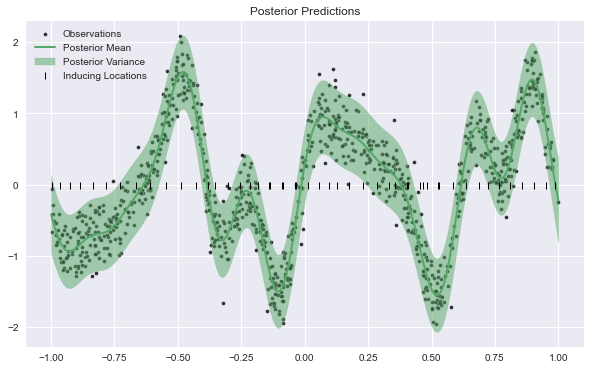

In [23]:
# Posterior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
sgpr_post_mean, sgpr_post_var = sgpr.predict_y(X_pred)
Z = sgpr.inducing_variable.Z.numpy()

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], sgpr_post_mean[:, 0], c="C1", lw=2, label="Posterior Mean")
ax.fill_between(X_pred[:, 0], sgpr_post_mean[:, 0] + 2*np.sqrt(sgpr_post_var[:, 0]), 
                sgpr_post_mean[:, 0] - 2*np.sqrt(sgpr_post_var[:, 0]), color="C1", 
                alpha=0.5, label="Posterior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations")
ax.set_title("Posterior Predictions")
ax.legend()
plt.show()

## Comparing Exact and Approximate Inference

In [24]:
gpr_post = tfp.distributions.MultivariateNormalDiag(
    loc=gpr_post_mean, scale_diag=np.sqrt(gpr_post_var))
sgpr_post = tfp.distributions.MultivariateNormalDiag(
    loc=sgpr_post_mean, scale_diag=np.sqrt(sgpr_post_var))
    
print(tf.reduce_sum(gpr_post.kl_divergence(sgpr_post)))

tf.Tensor(4.185397759684465e-07, shape=(), dtype=float64)
